In [54]:

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to remove the background by setting a transparent background
def backgroundRemover(img, color):
    # Convert the image to RGB for thresholding
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Define the background mask (adjust threshold bounds for your background)
    if color == 'white':
        lower_bound = np.array([200, 200, 200])  # Upper bounds for light background
        upper_bound = np.array([255, 255, 255])  # Upper bounds for light background
    else:
        lower_bound = np.array([255, 255, 255])  # Upper bounds for light background
        upper_bound = np.array([200, 200, 200])  # Upper bounds for light background

    mask = cv.inRange(img_rgb, lower_bound, upper_bound)  # Create mask for background

    # Invert the mask to get the foreground
    foreground_mask = cv.bitwise_not(mask)

    # Create a 4-channel image (RGBA)
    rgba = cv.cvtColor(img, cv.COLOR_BGR2BGRA)

    # Set alpha channel: foreground opaque (255), background transparent (0)
    rgba[:, :, 3] = foreground_mask
    return rgba


img = cv.imread("frontend/assets/final.png")
finalInitial = backgroundRemover(img, 'white')


True

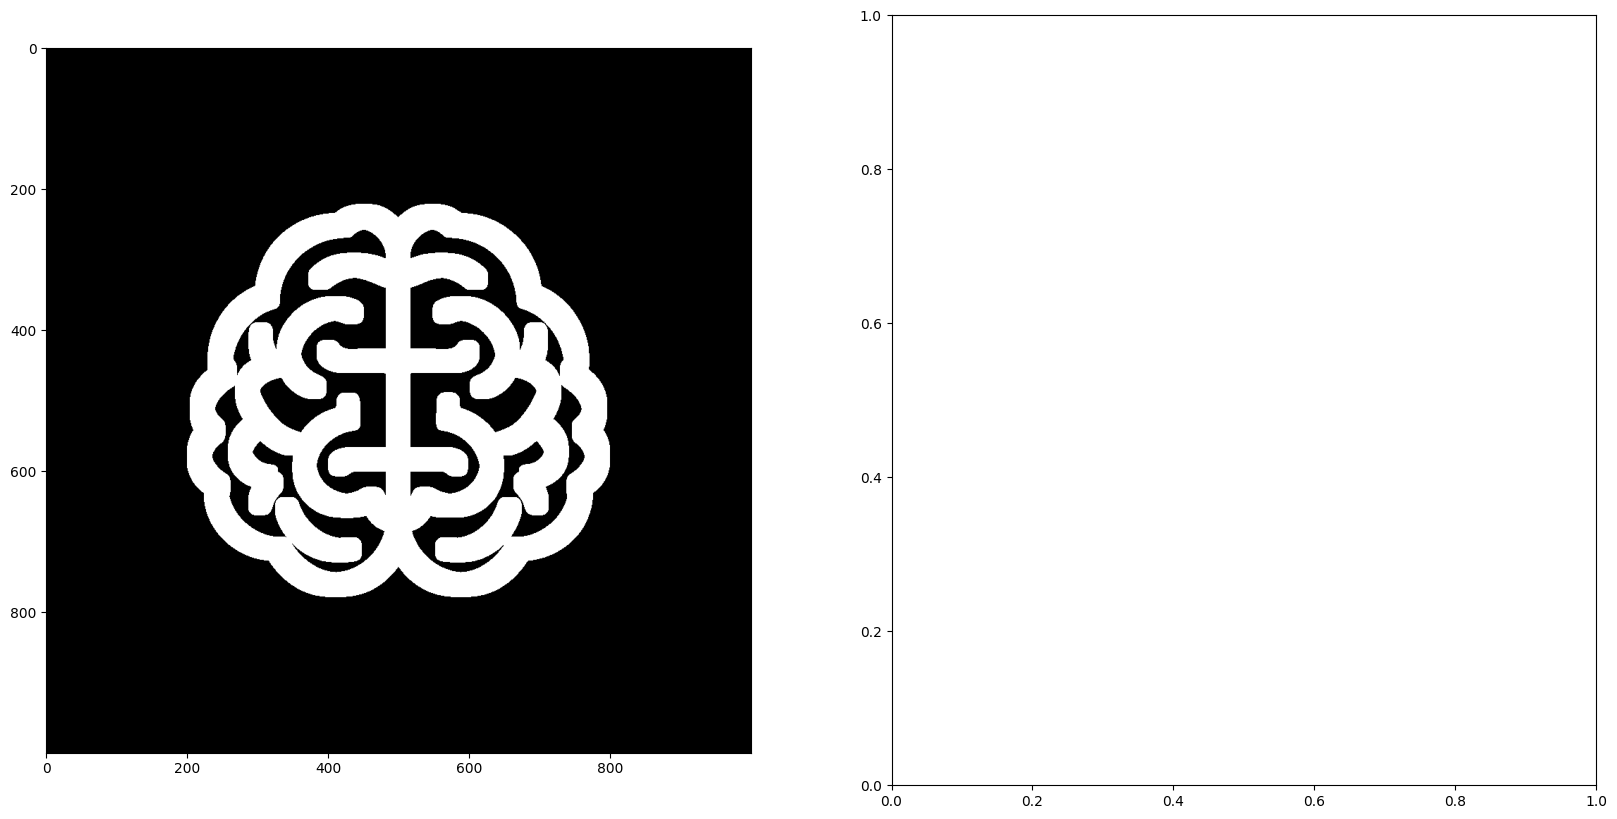

In [58]:

# Image reconstruction function for filling holes
def computeReconstruction(img, R0):
    R = R0.copy()
    prevR = np.zeros_like(R)
    S = np.ones((3, 3), np.uint8)  # Structuring element (kernel)
    
    while not np.array_equal(R, prevR):  # Keep iterating until no changes
        prevR = R.copy()
        R = cv.bitwise_and(cv.dilate(R, S, iterations=1), img)  # Dilate followed by AND operation
    return R

def computeHoles(I):
    Ic = invert(I)
    R0 = np.zeros_like(Ic)
    R0[0, :] = Ic[0, :]
    R0[-1, :] = Ic[-1, :]
    R0[:, 0] = Ic[:, 0]
    R0[:, -1] = Ic[:, -1]
    R = computeReconstruction(Ic, R0)
    return cv.bitwise_not(R)
    

def invert(I):
    b, g, r, a = cv.split(I)  # Split the channels
    rgb_inverted = cv.merge([cv.bitwise_not(b), cv.bitwise_not(g), cv.bitwise_not(r)])  # Invert RGB
    
    # Merge the inverted RGB with the original alpha channel
    img_inverted = cv.merge([rgb_inverted[..., 0], rgb_inverted[..., 1], rgb_inverted[..., 2], a])
    return img_inverted

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # axs is a 2D array
kernel = np.ones((3,3), np.uint8)

eroded = cv.erode(finalInitial, kernel, iterations=6)
# dilated = cv.dilate(img2, kernel, iterations=3)
holesFilled = computeHoles(eroded)

new = (cv.bitwise_or(invert(holesFilled), eroded))  # Use OR instead of addition
ax1.imshow(eroded)

cv.imwrite('./frontend/assets/yep.png', backgroundRemover(new, 'white'))
